In [1]:
import numpy as np
import tensorflow_datasets as tfds

Desta vez vou carregar os dados direto no formato de dataset, separado por split. O parâmetro `as_supervised` faz com que o iterador retorne tuplas no formato `(feature, label)`; se `False`, o iterator retorna itens no formato de dicionário contendo chaves `"image"` e `"label"`.

In [2]:
ds_train, info = tfds.load('mnist', split = 'train', as_supervised = True, with_info = True)

In [3]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [4]:
for feature, label in ds_train.take(1):
    print(feature.shape, label.numpy())
    print(feature.numpy().reshape(28, 28))

(28, 28, 1) 4
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  84
  254 101   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 174
  253 119   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  31 247
  202  29   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   1   0 

Como os pixels são inteiros entre 0 e 255, vou definir uma função para transformar os valores no dataset. Já que este dataset produz tuplas contendo (feature, label), a função precisa receber essas duas variáveis e retornar ambas as variáveis com as transformações cabíveis.

In [5]:
def transform(f, l):
    return f/255, l

In [6]:
ds_train = ds_train.map(transform)

Text(0.5, 1.0, 'Classe: 4')

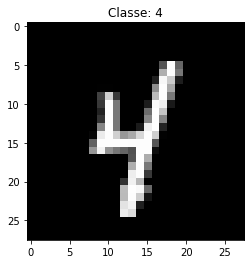

In [7]:
import matplotlib.pyplot as plt
plt.imshow(feature.numpy().reshape(28, 28), cmap = 'gray')
plt.title('Classe: ' + str(label.numpy()))

In [8]:
import tensorflow as tf
tf.random.set_seed(42)

tf.__version__

'2.3.0'

Segundo https://www.tensorflow.org/guide/migrate#using_a_keras_model_definition, no TF 2.x é recomendado usar o Keras para construir modelos. Desta forma, o modelo gerado já vai ser instância de uma classe apropriada, com os métodos necessários para encadeá-lo com outras classes do TF, e também vai definir quais são e acompanhar os parâmetros treináveis. O modelo pode então ser convertido diretamente para um estimador (como explicado no link), ou o estimador pode ser construído manualmente (conforme feito abaixo, na sequência).

Tendo isso em mente, podemos implementar um modelo e realizar o treinamento de três formas diferentes, indo da mais verbosa (que permite um controle mais fino dos processos internos) à menos verbosa (quando o comportamento padrão do treinamento é suficiente). Vou implementar as três formas.

# 1. Forma mais verbosa

Aqui, nós vamos definir uma classe para o modelo. A classe permite definir as camadas e as operações a serem realizadas. Documentação: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [9]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = (1, 1), padding = 'same', activation = 'relu')
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)
        self.conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = (1, 1), padding = 'same')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
        self.dropout = tf.keras.layers.Dropout(rate = 0.2)
        self.dense2 = tf.keras.layers.Dense(10)
    
    def call(self, inputs, training = False):
        x = self.conv1(inputs)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x) # Apesar de estarmos chamando esta camada duas vezes, como ela não tem nenhum parâmetro treinável, podemos reutilizá-la
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training = training)
        x = self.dense2(x)

        return x

Neste caso, a função que produz o modelo vai retornar uma instância da classe.

In [10]:
def make_model():
    return Model()

Então, podemos definir uma função que vai retornar os `EstimatorSpec`s.

Comparando com a implementação no TF 1.x, as alterações abaixo em `model_fn` foram baseadas em https://www.tensorflow.org/guide/migrate#custom_model_fn_with_tf_20_symbols.

In [11]:
def model_fn(features, labels, mode):
    model = make_model()
    features = tf.cast(features, tf.float32)
    out = model(features, training = (mode == tf.estimator.ModeKeys.TRAIN))
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
        loss = loss_obj(labels, out)
        optimizer = tf.keras.optimizers.Adam()
        optimizer.iterations = tf.compat.v1.train.get_or_create_global_step()
        train_op = optimizer.get_updates(loss, model.trainable_variables)[0]
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)

    if mode == tf.estimator.ModeKeys.EVAL:
        predictions = tf.argmax(out, axis = 1)
        loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
        loss = loss_obj(labels, out)
        accuracy_obj = tf.keras.metrics.Accuracy()
        accuracy_obj.update_state(y_true = labels, y_pred = predictions)
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = {'Accuracy': accuracy_obj})

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = tf.argmax(out, axis = 1)
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)

In [12]:
classificador = tf.estimator.Estimator(model_fn = model_fn)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3ltfny3g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3ltfny3g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Para usar estimadores, o dataset precisa ser definido dentro de `input_fn`, por isso estou chamando `tfds.load` de novo.

In [13]:
def make_input_fn(dataset_split, num_epochs = None, shuffle = True, batch_size = 128):
    def input_fn():
        if dataset_split == 'train':
            ds = tfds.load('mnist', split = 'train', as_supervised = True)
        if dataset_split == 'test':
            ds = tfds.load('mnist', split = 'test', as_supervised = True)
        ds = ds.map(transform)
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_fn

In [14]:
train_fn = make_input_fn('train')

In [15]:
classificador.train(input_fn = train_fn, steps = 200)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3ltfny3g/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp3ltfny3g/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.3135529, step = 0


INFO:tensorflow:loss = 2.3135529, step = 0


INFO:tensorflow:global_step/sec: 2.79696


INFO:tensorflow:global_step/sec: 2.79696


INFO:tensorflow:loss = 0.056812935, step = 100 (35.758 sec)


INFO:tensorflow:loss = 0.056812935, step = 100 (35.758 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...


INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp3ltfny3g/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp3ltfny3g/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...


INFO:tensorflow:Loss for final step: 0.10327113.


INFO:tensorflow:Loss for final step: 0.10327113.


In [16]:
evaluate_fn = make_input_fn('test', num_epochs = 1, shuffle = False)
results = classificador.evaluate(input_fn = evaluate_fn)
results

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-09-07T22:58:24Z


INFO:tensorflow:Starting evaluation at 2020-09-07T22:58:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp3ltfny3g/model.ckpt-200


INFO:tensorflow:Restoring parameters from /tmp/tmp3ltfny3g/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 7.46187s


INFO:tensorflow:Inference Time : 7.46187s


INFO:tensorflow:Finished evaluation at 2020-09-07-22:58:31


INFO:tensorflow:Finished evaluation at 2020-09-07-22:58:31


INFO:tensorflow:Saving dict for global step 200: Accuracy = 0.9793, global_step = 200, loss = 0.06424026


INFO:tensorflow:Saving dict for global step 200: Accuracy = 0.9793, global_step = 200, loss = 0.06424026


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmp3ltfny3g/model.ckpt-200


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmp3ltfny3g/model.ckpt-200


{'Accuracy': 0.9793, 'global_step': 200, 'loss': 0.06424026}

In [17]:
predict_fn = make_input_fn('test', num_epochs = 1, shuffle = False)
preds = list(classificador.predict(input_fn = predict_fn))
preds[:10]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmp3ltfny3g/model.ckpt-200


INFO:tensorflow:Restoring parameters from /tmp/tmp3ltfny3g/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


[2, 0, 4, 8, 7, 6, 0, 6, 3, 1]

# 2. Forma "meio" verbosa

Desta vez, vamos implementar o modelo não como instância de uma classe, mas usando o construtor `tf.keras.Sequential`.

In [18]:
def make_model():
    return tf.keras.Sequential([
                                tf.keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = (1, 1), padding = 'same', activation = 'relu', input_shape = (28, 28, 1)),
                                tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2),
                                tf.keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = (1, 1), padding = 'same'),
                                tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2), # Aqui, como as operações são realizadas na sequência, precisamos discriminar a segunda camada de MaxPooling
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(units = 1024, activation = 'relu'),
                                tf.keras.layers.Dropout(rate = 0.2),
                                tf.keras.layers.Dense(10)
    ])

A função `model_fn` é idêntica, por isso podemos utilizar a mesma implementação.

In [19]:
classificador = tf.estimator.Estimator(model_fn = model_fn)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvt_et3jg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvt_et3jg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


As funções `train_fn`, `evaluate_fn` e `test_fn` também não mudam.

In [20]:
classificador.train(input_fn = train_fn, steps = 200)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvt_et3jg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpvt_et3jg/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.294622, step = 0


INFO:tensorflow:loss = 2.294622, step = 0


INFO:tensorflow:global_step/sec: 2.79998


INFO:tensorflow:global_step/sec: 2.79998


INFO:tensorflow:loss = 0.17690547, step = 100 (35.717 sec)


INFO:tensorflow:loss = 0.17690547, step = 100 (35.717 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...


INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpvt_et3jg/model.ckpt.


INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpvt_et3jg/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...


INFO:tensorflow:Loss for final step: 0.080706164.


INFO:tensorflow:Loss for final step: 0.080706164.


In [21]:
results = classificador.evaluate(input_fn = evaluate_fn)
results

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-09-07T22:59:52Z


INFO:tensorflow:Starting evaluation at 2020-09-07T22:59:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpvt_et3jg/model.ckpt-200


INFO:tensorflow:Restoring parameters from /tmp/tmpvt_et3jg/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 7.41664s


INFO:tensorflow:Inference Time : 7.41664s


INFO:tensorflow:Finished evaluation at 2020-09-07-23:00:00


INFO:tensorflow:Finished evaluation at 2020-09-07-23:00:00


INFO:tensorflow:Saving dict for global step 200: Accuracy = 0.9809, global_step = 200, loss = 0.055115554


INFO:tensorflow:Saving dict for global step 200: Accuracy = 0.9809, global_step = 200, loss = 0.055115554


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmpvt_et3jg/model.ckpt-200


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmpvt_et3jg/model.ckpt-200


{'Accuracy': 0.9809, 'global_step': 200, 'loss': 0.055115554}

In [22]:
preds = list(classificador.predict(input_fn = predict_fn))
preds[:10]

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpvt_et3jg/model.ckpt-200


INFO:tensorflow:Restoring parameters from /tmp/tmpvt_et3jg/model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


[2, 0, 4, 8, 7, 6, 0, 6, 3, 1]

# 3. Forma menos verbosa

Agora, vamos usar a mesma construção disponibilizada por `tf.keras.Sequential`, mas vamos fazer o treinamento sem usar estimadores.

Podemos passar os dados diretamente para o método `fit` no formato de dataset, mas temos que preparar os batches antes.

In [23]:
model = make_model()

dataset = ds_train.shuffle(1000).batch(128)

# Como nós precisamos passar um parâmetro para a função de custo, temos que instanciar sua classe ao invés de simplesmente chamá-la pela string no método `compile`
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
model.compile(optimizer = "Adam", loss = loss, metrics = "accuracy")
model.fit(dataset, epochs = 1)

469/469 [==============================] - 172s 366ms/step - loss: 0.1322 - accuracy: 0.9599


In [24]:
ds_test = tfds.load('mnist', split = 'test', as_supervised = True)
dataset = ds_test.map(transform).batch(128)
model.evaluate(dataset)

79/79 [==============================] - 8s 95ms/step - loss: 0.0433 - accuracy: 0.9860


[0.04329773783683777, 0.9860000014305115]

In [25]:
preds = model.predict(dataset)
# Lembrando que as predições são logits...
preds = np.argmax(preds, axis = 1)
preds[:10]

array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1])

# Visualizando a primeira predição

In [26]:
image_test, label_test = next(iter(ds_test.take(1)))

Text(0.5, 1.0, 'Classe prevista: 2')

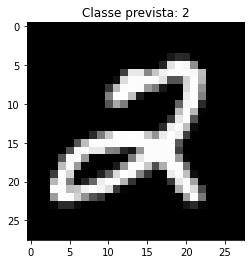

In [27]:
plt.imshow(image_test.numpy().reshape(28, 28), cmap = 'gray')
plt.title('Classe prevista: ' + str(preds[0]))

---

(ADENDO: Minha tentativa anterior de implementar os estimadores usando a API de baixo nível. Deixei caso mudemos de ideia. Não deu certo.)

In [28]:
# def model_fn(features, labels, mode):
    
#     filters = {
#         'convolucao1' : tf.Variable(tf.random.normal(shape = [5, 5, 1, 32])),
#         'convolucao2' : tf.Variable(tf.random.normal(shape = [5, 5, 32, 64]))
#     }

#     weights = {
#         'dense' : tf.Variable(tf.random.normal(shape = [3136, 1024])),
#         'out' : tf.Variable(tf.random.normal(shape = [1024, 10]))
#     }

#     biases = {
#         'dense' : tf.Variable(tf.random.normal(shape = [1024])),
#         'out' : tf.Variable(tf.random.normal(shape = [10]))
#     }

#     def model(features, filters, weights, biases):
#         entrada = tf.cast(features, tf.float32)
#         print(1)
#         convolucao1 = tf.nn.conv2d(input = entrada, filters = filters['convolucao1'], strides = 1, padding = 'SAME')
#         convolucao1 = tf.nn.relu(convolucao1)
#         print(2)
#         pooling1 = tf.nn.max_pool2d(input = convolucao1, ksize = [2, 2], strides = 2, padding = 'VALID')
#         print(3)
#         convolucao2 = tf.nn.conv2d(input = pooling1, filters = filters['convolucao2'], strides = 1, padding = 'SAME')
#         convolucao2 = tf.nn.relu(convolucao2)
#         print(4)
#         pooling2 = tf.nn.max_pool2d(input = convolucao2, ksize = [2, 2], strides = 2, padding = 'VALID')
#         print(5)
#         flattening = tf.reshape(pooling2, [-1, pooling2.shape[1] * pooling2.shape[2] * pooling2.shape[3]])
#         print(6)
#         dense = tf.add(tf.matmul(flattening, weights['dense']), biases['dense'])
#         dense = tf.nn.relu(dense)
#         print(7)
#         if mode == tf.estimator.ModeKeys.TRAIN:
#             dense = tf.nn.dropout(x = dense, rate = 0.2)
#         print(8)
#         out = tf.add(tf.matmul(dense, weights['out']), biases['out'])

#         return out

#     if mode == tf.estimator.ModeKeys.TRAIN:
#         print(0)
#         loss = lambda: tf.keras.losses.sparse_categorical_crossentropy(y_true = labels, y_pred = model(features,), from_logits = True)
#         print(9)
#         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#         print(10)
#         var_list = [*list(filters.values()), *list(weights.values()), *list(biases.values())]
#         print(11)
#         train_op = optimizer.minimize(loss, [var_list])
#         print(12)
#         return tf.estimator.EstimatorSpec(mode = mode, loss = loss(), train_op = train_op)

#     if mode == tf.estimator.ModeKeys.EVAL:
#         eval_metric_ops = {'accuracy': tf.keras.metrics.Accuracy()}
#         return tf.estimator.EstimatorSpec(mode = mode, loss = loss(), eval_metric_ops = eval_metric_ops) 

#     if mode == tf.estimator.ModeKeys.PREDICT:
#         predictions = tf.argmax(out, axis = 1)
#         return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)        